In [1]:
#importing important libraries

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import gc # for deleting unused variables
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# reading training data
train_sample= pd.read_csv("/content/train_sample.csv")
# specify column dtypes to save memory (by default pandas reads some columns as floats)
# note that click_id is only in test data, not training data
dtypes = {
        'ip'            : 'uint16',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

# read training_sample.csv for quick testing/debug, else read the full train.csv
testing = True
if testing:
    train_path = "train_sample.csv"
    skiprows = None
    nrows = None
    colnames=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']
else:
    train_path = "train.csv"
    skiprows = range(1, 144903891)
    nrows = 10000000
    colnames=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']

# read training data (train_sample.csv)
train_sample = pd.read_csv(train_path, skiprows=skiprows, nrows= 10000000)


In [3]:
# Printing length of training data
len(train_sample)

100000

In [4]:
# Displays memory consumed by each column ---
train_sample.memory_usage(deep=True)

,0
Index,132
ip,800000
app,800000
device,800000
os,800000
channel,800000
click_time,6800000
attributed_time,3208172
is_attributed,800000


In [5]:
# space used by training data
train_sample.memory_usage(deep=True).sum()



np.int64(14808304)

In [6]:
# training data top rows
train_sample.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [7]:
# look at non-null values, null values, number of entries etc.
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ip               100000 non-null  int64 
 1   app              100000 non-null  int64 
 2   device           100000 non-null  int64 
 3   os               100000 non-null  int64 
 4   channel          100000 non-null  int64 
 5   click_time       100000 non-null  object
 6   attributed_time  227 non-null     object
 7   is_attributed    100000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 6.1+ MB


In [8]:
# Define a function to fetch unique values in each column
def fraction_unique(x):
    # return unique values
    return len(np.unique(x)) / len(x)

# Convert time columns to datetime objects first
train_sample['click_time'] = pd.to_datetime(train_sample['click_time'])
train_sample['attributed_time'] = pd.to_datetime(train_sample['attributed_time'])

# one line code to use above function and creating a dictionary
number_unique_vals = {col: fraction_unique(train_sample[col]) for col in train_sample.columns}



#print dictionary of Unique values
number_unique_vals

{'ip': 0.34857,
 'app': 0.00161,
 'device': 0.001,
 'os': 0.0013,
 'channel': 0.00161,
 'click_time': 0.8035,
 'attributed_time': 0.00228,
 'is_attributed': 2e-05}

In [9]:
# each column data type
data_types = {col: str(train_sample[col].dtype) for col in train_sample.columns}
data_types

{'ip': 'int64',
 'app': 'int64',
 'device': 'int64',
 'os': 'int64',
 'channel': 'int64',
 'click_time': 'datetime64[ns]',
 'attributed_time': 'datetime64[ns]',
 'is_attributed': 'int64'}

Text(0.5, 1.0, 'Distribution of app')

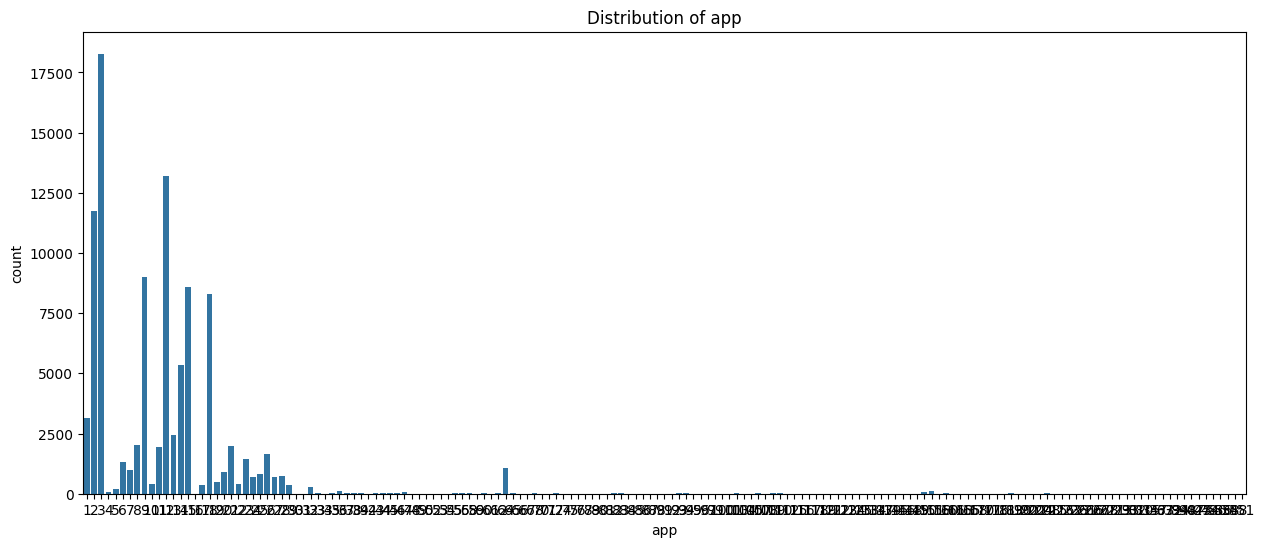

In [10]:
#distribution of 'app'
plt.figure(figsize=(15, 6))
sns.countplot(x='app', data=train_sample)
plt.title('Distribution of app')





Text(0.5, 1.0, 'Distribution of device')

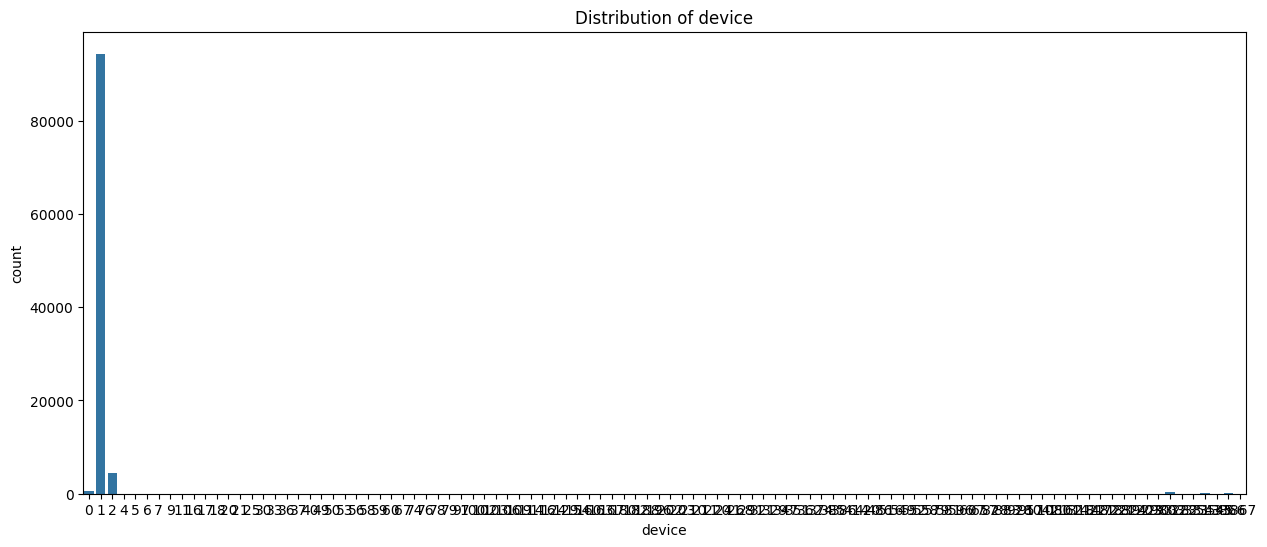

In [11]:
# distribution of 'device'
plt.figure(figsize=(15, 6))
sns.countplot(x='device', data=train_sample)
plt.title('Distribution of device')

Text(0.5, 1.0, 'Distribution of channel')

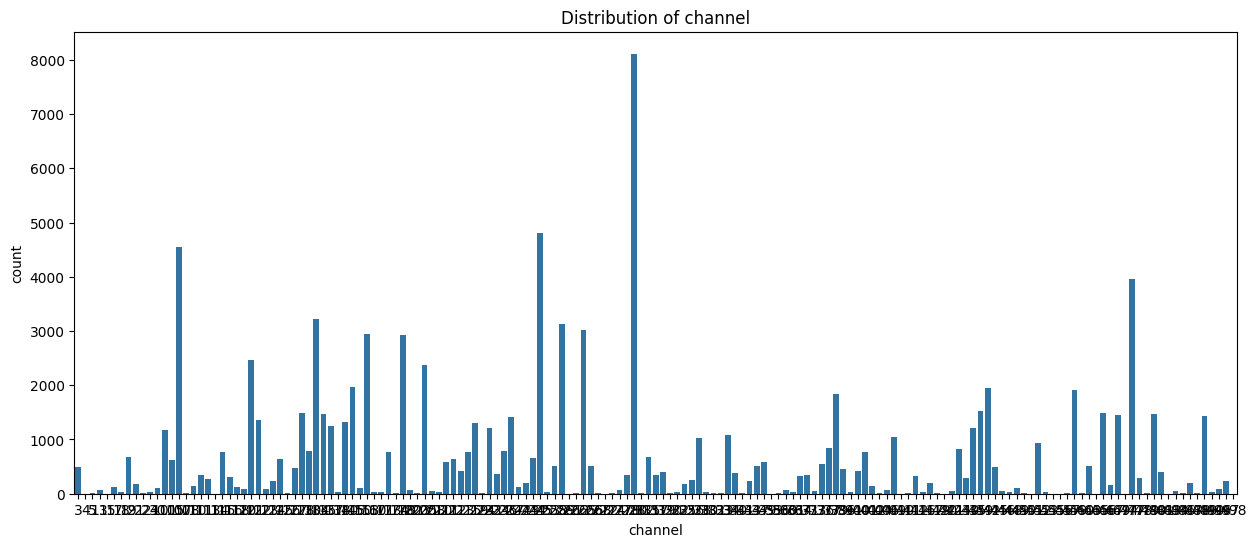

In [12]:
# distribution of 'channel'
plt.figure(figsize=(15, 6))
sns.countplot(x='channel', data=train_sample)
plt.title('Distribution of channel')

Text(0.5, 1.0, 'Distribution of os')

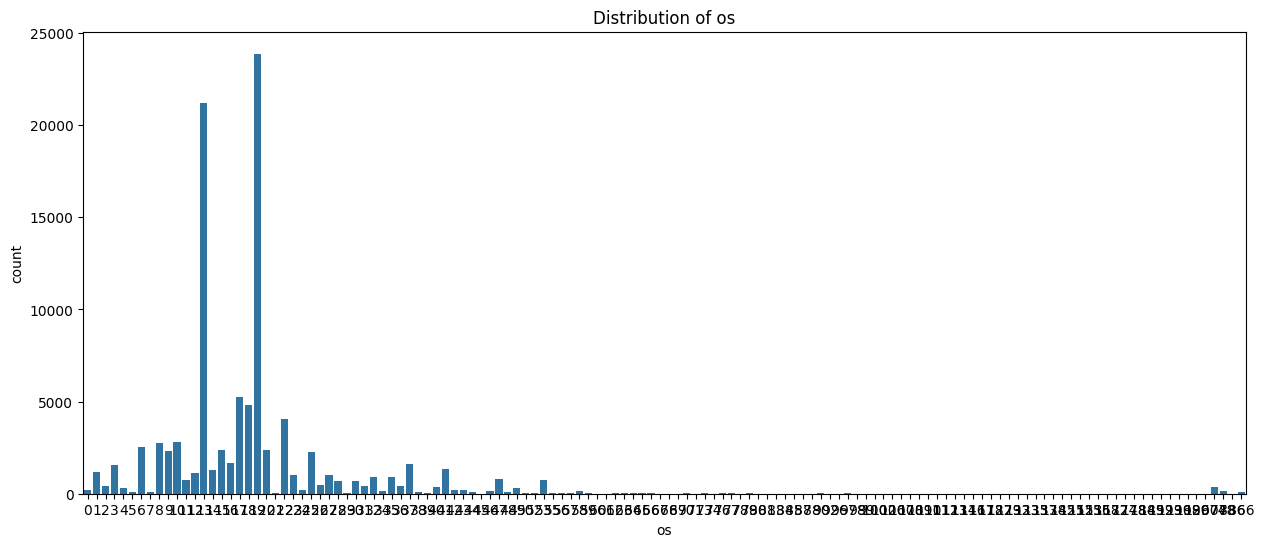

In [13]:
# distribution of 'os'
plt.figure(figsize=(15, 6))
sns.countplot(x='os', data=train_sample)
plt.title('Distribution of os')

In [14]:
# target variable distribution
train_sample['is_attributed'].value_counts()

,count
is_attributed,
0,99773
1,227


In [15]:
# Get average of 'is_attributed', or 'download rate' grouped with app
app_target = train_sample.groupby('app')['is_attributed'].mean()


# print app_target
app_target


,is_attributed
app,
1,0.000000
2,0.000000
3,0.000219
4,0.000000
5,0.074468
...,...
486,0.000000
536,0.000000
538,0.000000


In [16]:
# Make a 'count' column based on app size and reset index on count
frequent_apps = train_sample.groupby('app').size().reset_index(name='count')

# filter count greater than count above 80% quantile range
frequent_apps = frequent_apps[frequent_apps['count'] > frequent_apps['count'].quantile(0.8)]
#inner join frequent_apps with train_sample on 'app'
frequent_apps = pd.merge(frequent_apps, train_sample, on='app', how='inner')

#print head of frequent_apps
frequent_apps.head()

,app,count,ip,device,os,channel,click_time,attributed_time,is_attributed
0,1,3135,17059,1,17,135,2017-11-09 01:17:58,NaT,0
1,1,3135,52432,1,13,115,2017-11-07 17:22:52,NaT,0
2,1,3135,89242,1,27,124,2017-11-07 09:37:21,NaT,0
3,1,3135,123994,1,19,101,2017-11-09 14:27:57,NaT,0
4,1,3135,34067,1,15,134,2017-11-07 15:06:06,NaT,0


<Axes: xlabel='app', ylabel='count'>

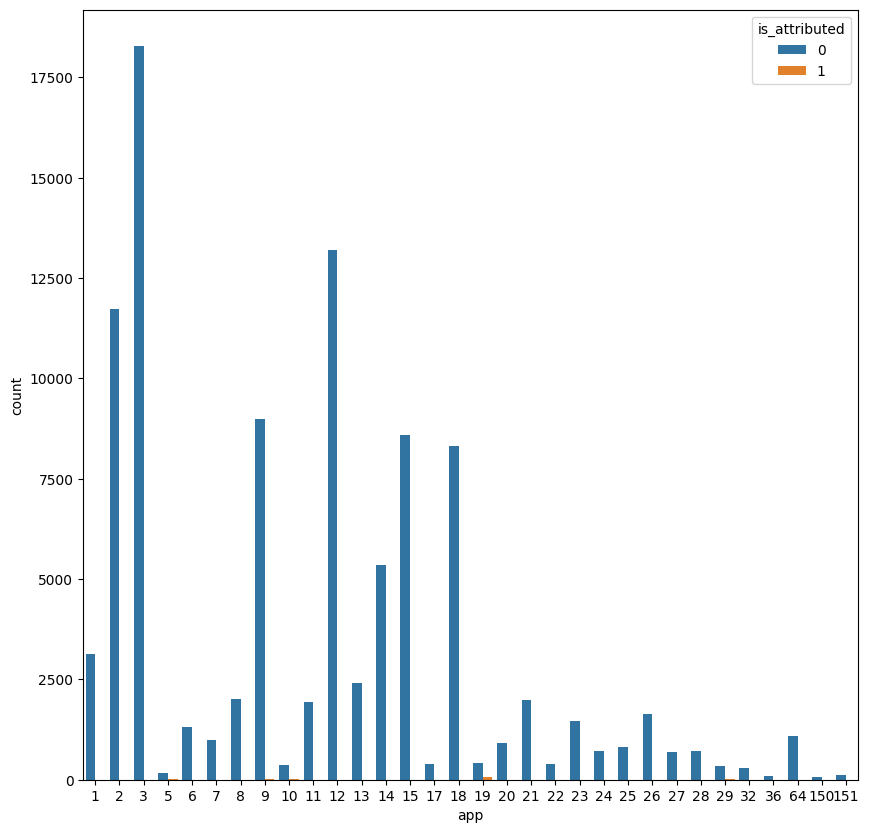

In [17]:
#plot count distribution of 'app' hued with 'is_attributed'
plt.figure(figsize=(10,10))
sns.countplot(x='app', hue='is_attributed', data=frequent_apps)

In [18]:
# Create a function which takes in a df, adds date/time based columns to it and returns the modified df

def timeFeatures(df):
    # Creating datetime variables using the click_time column
    df['datetime'] = pd.to_datetime(df['click_time'])


    #Creating day_of_week variables extracting week from the datetime column

    df['day_of_week'] = pd.DatetimeIndex(df['datetime']).dayofweek


     #Creating day_of_year variables extracting day from the datetime column

    df["day_of_year"] = pd.DatetimeIndex(df['datetime']).dayofyear


    #Creating month variables extracting month from the datetime column

    df["month"] = pd.DatetimeIndex(df['datetime']).month


    #Creating hour variables extracting hour from the datetime column

    df["hour"] = pd.DatetimeIndex(df['datetime']).hour

    #return df
    return df

In [19]:
# creating new variables using above function with df as train_sample
train_sample = timeFeatures(train_sample)

# dropping the click_time and datetime variables from train_sample
train_sample.drop(['click_time', 'datetime'], axis=1, inplace=True)




#print train_sample head
train_sample.head()

,ip,app,device,os,channel,attributed_time,is_attributed,day_of_week,day_of_year,month,hour
0,87540,12,1,13,497,NaT,0,1,311,11,9
1,105560,25,1,17,259,NaT,0,1,311,11,13
2,101424,12,1,19,212,NaT,0,1,311,11,18
3,94584,13,1,13,477,NaT,0,1,311,11,4
4,68413,12,1,1,178,NaT,0,3,313,11,9


In [20]:
# datatypes  of all variables in train_sample
train_sample.dtypes

,0
ip,int64
app,int64
device,int64
os,int64
channel,int64
attributed_time,datetime64[ns]
is_attributed,int64
day_of_week,int32
day_of_year,int32
month,int32


In [21]:
# check memory/space used by training data
train_sample.memory_usage(deep=True).sum()

np.int64(7200132)

In [22]:
# get all int variables in a list
int_vars = list(train_sample.select_dtypes(include=['int64']).columns)

# convert all above variables into uint16 type
train_sample[int_vars] = train_sample[int_vars].astype(np.uint16)

In [23]:
#print datatype of all variables in train_sample
train_sample.dtypes

,0
ip,uint16
app,uint16
device,uint16
os,uint16
channel,uint16
attributed_time,datetime64[ns]
is_attributed,uint16
day_of_week,int32
day_of_year,int32
month,int32


In [24]:
# space used by training data
train_sample.memory_usage(deep=True).sum()

np.int64(3600132)

In [25]:
# Create a column 'ip_count' using number of clicks by count of IP address
ip_count = train_sample.groupby(['ip'])['channel'].count().reset_index(name='ip_count')
#print head of ip_count
ip_count.head()

,ip,ip_count
0,8,1
1,9,1
2,10,3
3,14,1
4,16,6


In [26]:
'''creates groupings of IP addresses with other features and appends the new features to the df'''

def grouped_features(df):
    # ip_count (already correct)
    ip_count = train_sample.groupby(['ip'])['channel'].count().reset_index(name='ip_count')

    # ip_day_hour
    ip_day_hour = train_sample.groupby(['ip', 'day_of_week', 'hour']).size().reset_index(name='ip_day_hour_count')

#   ip_hour_channel
    ip_hour_channel = train_sample.groupby(['ip', 'hour', 'channel']).size().reset_index(name='ip_hour_channel_count')

#   ip_hour_os
    ip_hour_os = train_sample.groupby(['ip', 'hour', 'os']).size().reset_index(name='ip_hour_os_count')

#   ip_hour_app
    ip_hour_app = train_sample.groupby(['ip', 'hour', 'app']).size().reset_index(name='ip_hour_app_count')

#   ip_hour_device
    ip_hour_device = train_sample.groupby(['ip', 'hour', 'device']).size().reset_index(name='ip_hour_device_count')


    '''merge the new aggregated features with the df'''

#   left join ip_count to df on ip
    df = pd.merge(df, ip_count, on='ip', how='left')

#   delete ip_count
    del ip_count


    #left join ip_day_hour to df on ip, day_of_week and hour

    df = pd.merge(df, ip_day_hour, on=['ip', 'day_of_week', 'hour'], how='left')


    #delete ip_day_hour
    del ip_day_hour



#   left join ip_hour_channel to df on ip, hour, channel

    df = pd.merge(df, ip_hour_channel, on=['ip', 'hour', 'channel'], how='left')

#   delete ip_hour_channel
    del ip_hour_channel


    #left join ip_hour_os to df on ip, hour and os

    df = pd.merge(df, ip_hour_os, on=['ip', 'hour', 'os'], how='left')

#   delete ip_hour_os

    del ip_hour_os

    #    left join ip_hour_app to df on ip, hour and app

    df =  pd.merge(df, ip_hour_app, on=['ip', 'hour', 'app'], how='left')


#     delete ip_hour_app

    del ip_hour_app



    #left join ip_hour_device to df on ip , hour and device

    df = pd.merge(df, ip_hour_device, on=['ip', 'hour', 'device'], how='left')

#   delete ip_hour_device

    del ip_hour_device



#  return df
    return df

In [27]:
#Use above grouped_features() function with train_sample as parameter to create your new train_sample data
train_sample = grouped_features(train_sample)

In [28]:
#print head of train_sample
train_sample.head()

,ip,app,device,os,channel,attributed_time,is_attributed,day_of_week,day_of_year,month,hour,ip_count,ip_day_hour_count,ip_hour_channel_count,ip_hour_os_count,ip_hour_app_count,ip_hour_device_count
0,22004,12,1,13,497,NaT,0,1,311,11,9,8,1,1,1,1,1
1,40024,25,1,17,259,NaT,0,1,311,11,13,149,4,1,1,1,8
2,35888,12,1,19,212,NaT,0,1,311,11,18,2,1,1,1,1,1
3,29048,13,1,13,477,NaT,0,1,311,11,4,3,1,1,1,1,1
4,2877,12,1,1,178,NaT,0,3,313,11,9,4,1,1,1,1,1


In [29]:
import sys
import shutil

In [30]:
useg= shutil.disk_usage("/")
print("Total:", useg.total)
print("Used:", useg.used)
print("Free:", useg.free)


Total: 115658190848
Used: 22701826048
Free: 92939587584


In [31]:
# garbage collect (unused) object using gc.collect()
gc.collect()

516

In [32]:
 #create X and y train
X = train_sample.drop(['is_attributed', 'attributed_time'], axis=1)

y = train_sample['is_attributed']



# split data into train and test/validation sets with test_size as 20% and random state as 101
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)


#print shape of X_train, y_train, X_test and y_test
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(80000, 15) (80000,) (20000, 15) (20000,)


In [33]:
# check the average download rates in train
y_train.mean()


np.float64(0.002275)

In [34]:
# check the average download rates in test data, and check they should be comparable
y_test.mean()

np.float64(0.00225)

In [35]:
#Instantiate DecisionTreeClassifier with max_depth as 2 and random state as 1
tree = DecisionTreeClassifier(max_depth=2, random_state=1)


'''adaboost with the tree as base estimator, max 600 decision trees of depth=2,
learning_rate/shrinkage=1.5 and algorithm as "SAMME" and random_state as 1'''

adaboost_model_1 = AdaBoostClassifier(estimator=tree, n_estimators=600, learning_rate=1.5, algorithm="SAMME", random_state=1)

In [36]:
# fit adaboost_model_1 with training dataset
adaboost_model_1.fit(X_train, y_train)


AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    random_state=1),
                   learning_rate=1.5, n_estimators=600, random_state=1)

In [37]:
# prediction probability on X_test
predictions = adaboost_model_1.predict_proba(X_test)[:,1]



#print top 10 prediction result
predictions[:10]

array([0.41953617, 0.4285946 , 0.42275531, 0.45155789, 0.45970458,
       0.43855437, 0.43911246, 0.41801943, 0.4531563 , 0.46754926])

In [38]:
# metrics: Get AUC score with parameters y_test and predicted probability result
metrics.roc_auc_score(y_test, predictions)

np.float64(0.9523839750549848)

In [39]:
# parameter grid with base_estimator__max_depth as [2,5] and n_estimators as [200, 400, 600]
param_grid = {'estimator__max_depth': [2,5], 'n_estimators': [200, 400, 6]}

In [40]:
# DecisionTreeClassifier as base estimator with random_state=1
tree = DecisionTreeClassifier(random_state=1)

'''adaboost with the tree as base estimator and learning rate is arbitrarily set to 0.6,
we'll discuss learning_rate below and algorithm as "SAMME"'''

ABC = AdaBoostClassifier(estimator=tree, learning_rate=0.6, algorithm="SAMME")

In [41]:
# Keep cross validation fold as 3
folds = 3

# run grid search with ABC, folds, param_grid and scoring as roc_auc, return_train_score as True and verbose as 1
grid_search_ABC = GridSearchCV(ABC, param_grid, cv=folds, scoring='roc_auc', return_train_score=True, verbose=1)

In [42]:
# fit grid_search_ABC on training data
grid_search_ABC.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          estimator=DecisionTreeClassifier(random_state=1),
                                          learning_rate=0.6),
             param_grid={'estimator__max_depth': [2, 5],
                         'n_estimators': [200, 400, 6]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [43]:
# cv results
cv_results = pd.DataFrame(grid_search_ABC.cv_results_)

# print cv_results
cv_results


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,12.016581,0.422940,0.321951,0.004618,2,200,"{'estimator__max_depth': 2, 'n_estimators': 200}",0.926966,0.975725,0.955801,0.952831,0.020017,1,0.996306,0.995094,0.996461,0.995954,0.000611
1,23.779332,0.531935,0.641869,0.011769,2,400,"{'estimator__max_depth': 2, 'n_estimators': 400}",0.920643,0.974585,0.956496,0.950575,0.022416,2,0.997991,0.996683,0.997996,0.997556,0.000618
2,0.343234,0.017232,0.017975,0.001209,2,6,"{'estimator__max_depth': 2, 'n_estimators': 6}",0.923391,0.957965,0.928569,0.936642,0.015225,3,0.960079,0.954883,0.953609,0.956190,0.002798
3,25.929075,0.416972,0.506600,0.114133,5,200,"{'estimator__max_depth': 5, 'n_estimators': 200}",0.902359,0.937477,0.937881,0.925906,0.016651,4,1.000000,1.000000,1.000000,1.000000,0.000000
4,68.900778,3.136463,1.402142,0.430370,5,400,"{'estimator__max_depth': 5, 'n_estimators': 400}",0.890394,0.931233,0.935404,0.919010,0.020307,5,1.000000,1.000000,1.000000,1.000000,0.000000
5,0.989726,0.048479,0.029294,0.001399,5,6,"{'estimator__max_depth': 5, 'n_estimators': 6}",0.894306,0.922229,0.934493,0.917009,0.016816,6,0.998131,0.995514,0.996623,0.996756,0.001072


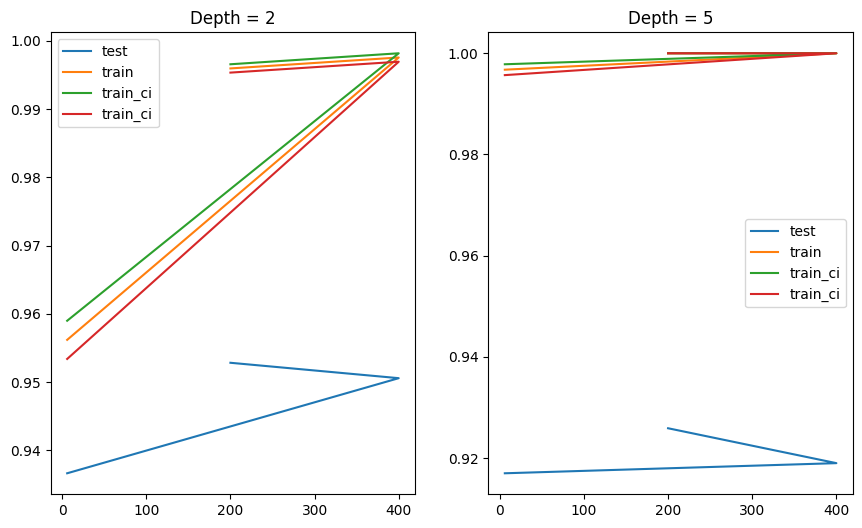

In [44]:
# plotting AUC with hyperparameter combinations
plt.figure(figsize=(16,6))
for n, depth in enumerate(param_grid['estimator__max_depth']):


    # subplot 1/n
    plt.subplot(1,3, n+1)
    depth_df = cv_results[cv_results['param_estimator__max_depth'] == depth]

    # plot depth_df["param_n_estimators"] for depth_df["mean_test_score"],depth_df["mean_train_score"]
    plt.plot(depth_df["param_n_estimators"], depth_df["mean_test_score"], label="test")
    plt.plot(depth_df["param_n_estimators"], depth_df["mean_train_score"], label="train")
    plt.plot(depth_df["param_n_estimators"], depth_df["mean_train_score"] + depth_df["std_train_score"], label="train_ci")
    plt.plot(depth_df["param_n_estimators"], depth_df["mean_train_score"] - depth_df["std_train_score"], label="train_ci")
    plt.legend()
    plt.title("Depth = %i" % depth)

In [45]:
# DecisionTreeClassifier  as base estimator with max_depth as 2 and random_state as 1
tree = DecisionTreeClassifier(max_depth=2, random_state=1)

'''adaboost with the tree as base estimator
# learning rate is arbitrarily set as 0.6, n_eastimator as 200 and rest same'''

ABC = AdaBoostClassifier(estimator=tree, learning_rate=0.6, n_estimators=200, algorithm="SAMME")


# fitting ABCon training data
ABC.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=2,
                                                    random_state=1),
                   learning_rate=0.6, n_estimators=200)

In [46]:
# predict on test data
predictions = ABC.predict_proba(X_test)[:,1]

# print AUC
metrics.roc_auc_score(y_test, predictions)

# print top 10 prediction probabilities
predictions[:10]

array([0.28914545, 0.29462848, 0.25213283, 0.33004786, 0.36183004,
       0.28734895, 0.31834597, 0.29353929, 0.30127918, 0.35041939])

In [47]:
# Calculate roc auc score
metrics.roc_auc_score(y_test, predictions)

np.float64(0.960727748545338)

In [48]:
# parameter grid with learning_rate as [0.2, 0.6, 0.9] and subsample as [0.3, 0.6, 0.9]
param_grid =  {'learning_rate': [0.2, 0.6, 0.9], 'subsample': [0.3, 0.6, 0.9] }

In [49]:
# Gradient boost as base estimator with max_depth as 2 and n_estimators as 200 and random_state as 1
GBC = GradientBoostingClassifier(max_depth=2, n_estimators=200, random_state=1)

In [50]:
# CV folds as 3
folds = 3

#Instantiate grid search with GBC, folds, param_grid and scoring as roc_auc, return_train_score as True and verbose as 1

grid_search_GBC = GridSearchCV(GBC, param_grid, cv=folds, scoring='roc_auc', return_train_score= True, verbose=1)


# grid_search_GBC fit on training data
grid_search_GBC.fit(X_train, y_train)


Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3,
             estimator=GradientBoostingClassifier(max_depth=2, n_estimators=200,
                                                  random_state=1),
             param_grid={'learning_rate': [0.2, 0.6, 0.9],
                         'subsample': [0.3, 0.6, 0.9]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [51]:
# cv results

cv_results = pd.DataFrame(grid_search_GBC.cv_results_)

# print cv_results
cv_results


# print head
cv_results.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,7.209691,0.474983,0.078380,0.029791,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.806188,0.548285,0.884576,0.746350,0.143663,3,0.909847,0.603369,0.843124,0.785447,0.131598
1,11.282265,0.775483,0.065731,0.007611,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.880967,0.878956,0.751848,0.837257,0.060399,2,0.905836,0.949851,0.741464,0.865717,0.089679
2,12.689584,1.373215,0.044087,0.013428,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.799695,0.823715,0.899856,0.841089,0.042696,1,0.858151,0.815856,0.904002,0.859336,0.035995
3,4.976756,0.341558,0.045107,0.012903,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.712614,0.171713,0.632072,0.505466,0.238279,7,0.617595,0.177567,0.654294,0.483152,0.216600
4,7.984648,0.338721,0.048008,0.007680,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.489959,0.654872,0.603384,0.582738,0.068890,6,0.452552,0.684572,0.634142,0.590422,0.099639


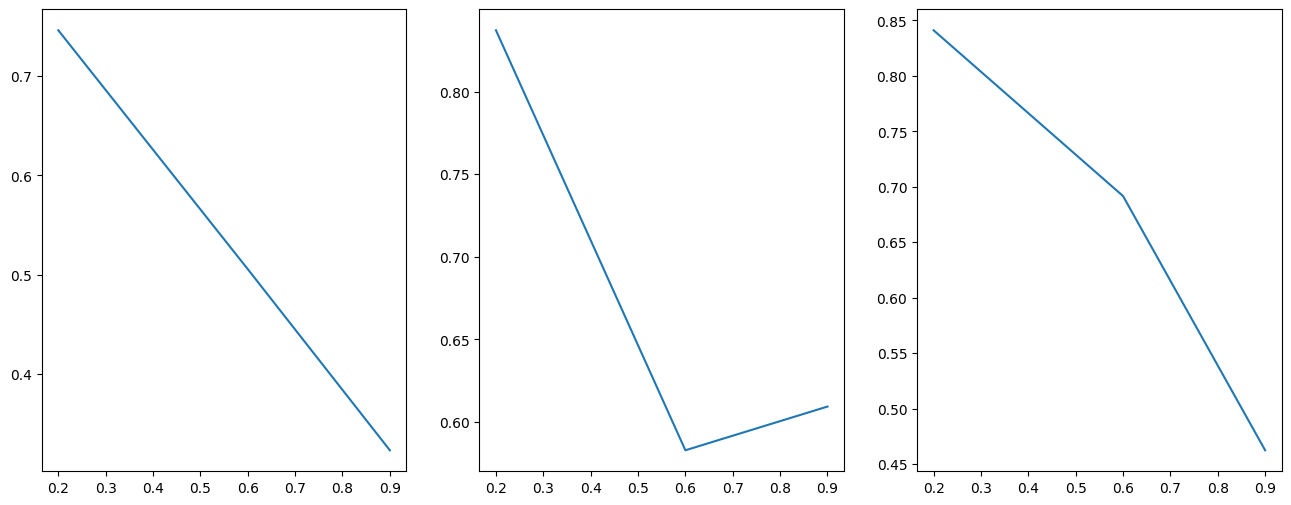

In [52]:
# # plotting AUC with hyperparameter combinations i.e subsample

plt.figure(figsize=(16,6))


for n, subsample in enumerate(param_grid['subsample']):


    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample'] == subsample]

    # plot df["param_learning_rate"] for df["mean_test_score"], df["mean_train_score"
    plt.plot(df["param_learning_rate"], df["mean_test_score"], label="test")

In [53]:
# fitting GBC training data
GBC.fit(X_train, y_train)
# predict probabilities on test data
predictions = GBC.predict_proba(X_test)[:,1]


# print top 10 prediction probabilities
predictions[:10]


array([0.00024037, 0.00031654, 0.00061447, 0.00020972, 0.00081005,
       0.00017524, 0.00038182, 0.00028765, 0.00021818, 0.0010024 ])

In [54]:
# Calculate roc auc score
metrics.roc_auc_score(y_test, predictions)


np.float64(0.9599148083187171)

In [77]:
# Instantiate XGBClassifier with default hyperparameters and random_state=1
model = XGBClassifier(random_state=1)

# fit model on training data
model.fit(X_train, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [78]:
# use predict_proba since we need probabilities to compute auc
y_pred = model.predict_proba(X_test)[:,1]

#print top 10 y_pred result
y_pred[:10]

array([7.9029292e-07, 1.5249158e-05, 5.1796951e-06, 3.6021226e-04,
       6.2435116e-05, 5.1888782e-07, 2.5203753e-05, 7.7434316e-07,
       4.5052544e-05, 6.5184105e-04], dtype=float32)

In [79]:
# evaluate predictions using roc_auc score
roc = metrics.roc_auc_score(y_test, y_pred)

# print roc
roc
# print AUC
print("AUC: %.2f%%" % (roc * 100.0))

AUC: 95.45%


In [80]:
# hyperparameter tuning with XGBoost

# creating a KFold object( 3 )
folds = 3

# specify range of hyperparameters with learning_rate as [0.2, 0.6] ans subsample as [0.3, 0.6, 0.9]
param_grid = {'learning_rate': [0.2, 0.6], 'subsample': [0.3, 0.6, 0.9]}



# specify model with max_depth as 2 and n_estimators as 200 and random_state as 1
xgb_model = XGBClassifier(max_depth=2, n_estimators=200, random_state=1)


# set up GridSearchCV() with xgb_model, param_grid, folds, return_train_score and verbose as 1
model_cv = GridSearchCV(xgb_model, param_grid, scoring='roc_auc', cv=folds, return_train_score=True)


In [81]:
# fit the model_cv on training data
model_cv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=2,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=200,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.2, 0.6],
                         'subsample': [0.3, 0.6, 0.9]},
             return_train_score=True, scoring='roc_auc')

In [82]:
# Get cv results as datafame
cv_results = pd.DataFrame(model_cv.cv_results_)

# print cv_results
cv_results



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,2.783465,0.241198,0.136806,0.052650,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.924655,0.967527,0.948223,0.946802,0.017531,4,0.989505,0.986029,0.993521,0.989685,0.003061
1,0.610539,0.025461,0.063595,0.000771,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.928142,0.976507,0.959421,0.954690,0.020026,1,0.994212,0.990497,0.993447,0.992719,0.001602
2,0.543913,0.015001,0.062848,0.000924,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.932243,0.973250,0.958228,0.954574,0.016939,2,0.993584,0.992595,0.995391,0.993857,0.001158
3,0.626087,0.015263,0.064959,0.003421,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.888841,0.955063,0.951505,0.931803,0.030413,5,0.996231,0.994376,0.995841,0.995482,0.000799
4,0.609252,0.018054,0.067397,0.005085,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.927676,0.968640,0.964002,0.953439,0.018315,3,0.999017,0.998169,0.999245,0.998810,0.000463
5,1.057199,0.475979,0.093342,0.020789,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.879806,0.919650,0.950084,0.916513,0.028776,6,0.998709,0.989615,0.998240,0.995522,0.004181


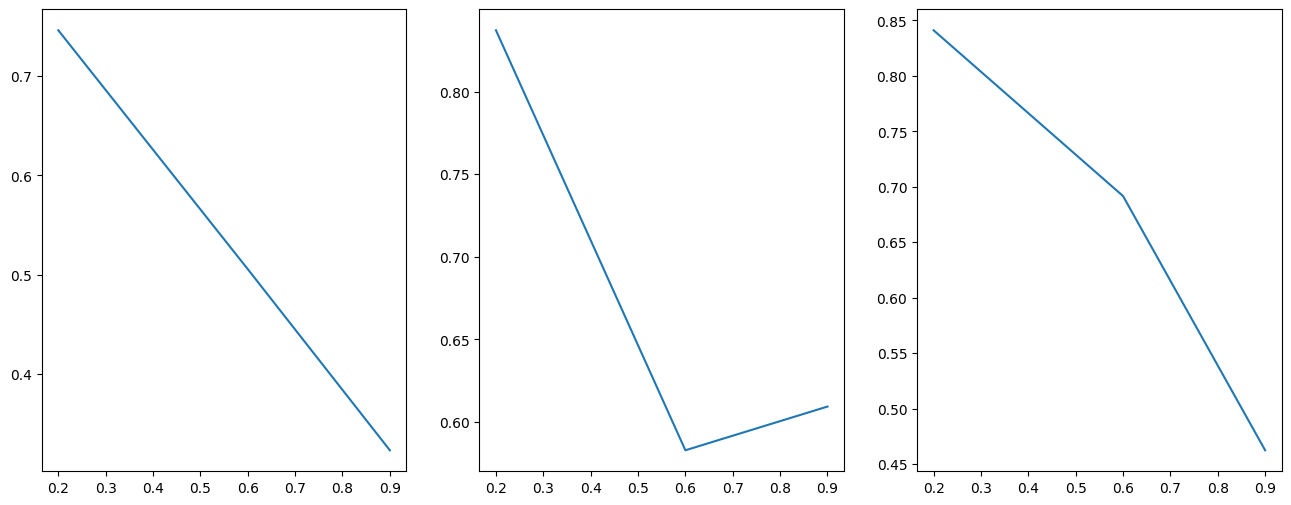

In [55]:
# # plotting
plt.figure(figsize=(16,6))

param_grid = {'learning_rate': [0.2, 0.6], 'subsample': [0.3, 0.6, 0.9]}



for n, subsample in enumerate(param_grid['subsample']):


    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample'] == subsample]


    # plot df["param_learning_rate"] for df["mean_test_score"], df["mean_train_score"]
    plt.plot(df["param_learning_rate"], df["mean_test_score"], label="test")

In [56]:
# 4 chosen hyperparameters and use 'objective':'binary:logistic' which outputs probability rather than label, which we need for auc
params = {'objective':'binary:logistic', 'max_depth': 2, 'subsample': 0.6 , 'learning_rate': 0.2}

#Instantiate XGBClassifier with params
XGB = XGBClassifier(**params)

# fit model on training data
XGB.fit(X_train, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [57]:
# get prediction probability
y_pred = XGB.predict_proba(X_test)[:,1]

#print to 10 prediction result
y_pred[:10]

array([8.29837372e-05, 1.72694025e-04, 2.91133212e-04, 2.48522556e-04,
       3.73046915e-03, 2.38199500e-05, 1.21245207e-03, 1.87458747e-04,
       1.11361216e-04, 1.64853083e-03], dtype=float32)

In [58]:
# print roc_auc score
auc = metrics.roc_auc_score(y_test, y_pred)

# print AUC
print("AUC: %.2f%%" % (auc * 100.0))


AUC: 96.27%


In [59]:
# print feature importance for each column in  a dictionary form
importance = XGB.get_booster().get_score(importance_type='weight')

#print importance
importance

{'ip': 27.0,
 'app': 68.0,
 'device': 28.0,
 'os': 36.0,
 'channel': 57.0,
 'day_of_week': 4.0,
 'hour': 22.0,
 'ip_count': 34.0,
 'ip_day_hour_count': 5.0,
 'ip_hour_os_count': 1.0,
 'ip_hour_device_count': 1.0}

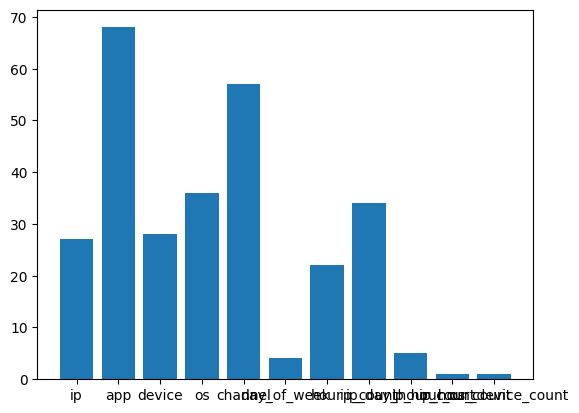

In [60]:
# plot feature importance for every column
plt.figure
plt.bar(range(len(importance)), list(importance.values()), align='center')
plt.xticks(range(len(importance)), list(importance.keys()))
plt.show()

In [61]:
# import lightgbm
import lightgbm


# import lightgbm as LGBMClassifier
from lightgbm import LGBMClassifier
# Instantiate LGBMClassifier with default hyperparameters and random_state=1
LGB = LGBMClassifier(random_state=1)


# fit model on training data
LGB.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 182, number of negative: 79818
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 890
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002275 -> initscore=-6.083498
[LightGBM] [Info] Start training from score -6.083498


LGBMClassifier(random_state=1)

In [62]:
# use predict_proba since we need probabilities to compute auc
y_pred = LGB.predict_proba(X_test)[:,1]

#print top 10 y_pred result
y_pred[:10]

array([2.39140823e-06, 1.48759511e-05, 1.33213465e-06, 1.43999851e-05,
       6.45154560e-05, 5.08854217e-06, 4.87501640e-06, 4.45827227e-12,
       0.00000000e+00, 3.48131849e-05])

In [63]:
# evaluate predictions using roc_auc score
roc = metrics.roc_auc_score(y_test, y_pred)

# print roc
roc

np.float64(0.8462212199671483)

In [65]:
# Define parameters as above
params = {'learning_rate': 0.2,
          'max_depth': 2,
          'subsample':0.6,
         'objective':'binary',
         'random_state':1}

# Instantiate XGBClassifier with params
LGB = LGBMClassifier(**params)


# fit model on training data
LGB.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 182, number of negative: 79818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 890
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002275 -> initscore=-6.083498
[LightGBM] [Info] Start training from score -6.083498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

LGBMClassifier(learning_rate=0.2, max_depth=2, objective='binary',
               random_state=1, subsample=0.6)

In [68]:
# use predict_proba since we need probabilities to compute auc
y_pred = LGB.predict_proba(X_test)[:,1]


# evaluate predictions using roc_auc score
roc = metrics.roc_auc_score(y_test, y_pred)


#print auc
print("AUC: %.2f%%" % (roc * 100.0))


AUC: 91.43%


In [70]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.0 MB/s eta 0:00:00


In [71]:

# import CatBoostClassifier
from catboost import CatBoostClassifier
# Instantiate CatBoostClassifier with default hyperparameters and random_state=1
Cat = CatBoostClassifier(random_state=1)
# fit model on training data
Cat.fit(X_train, y_train)



Learning rate set to 0.06692
0:	learn: 0.5107569	total: 84.2ms	remaining: 1m 24s
1:	learn: 0.3708133	total: 105ms	remaining: 52.3s
2:	learn: 0.2729211	total: 132ms	remaining: 43.8s
3:	learn: 0.2003287	total: 155ms	remaining: 38.6s
4:	learn: 0.1525553	total: 175ms	remaining: 34.9s
5:	learn: 0.1183012	total: 201ms	remaining: 33.3s
6:	learn: 0.0926958	total: 224ms	remaining: 31.8s
7:	learn: 0.0741227	total: 245ms	remaining: 30.4s
8:	learn: 0.0608923	total: 267ms	remaining: 29.3s
9:	learn: 0.0465873	total: 327ms	remaining: 32.3s
10:	learn: 0.0387760	total: 390ms	remaining: 35.1s
11:	learn: 0.0329883	total: 491ms	remaining: 40.4s
12:	learn: 0.0289558	total: 580ms	remaining: 44s
13:	learn: 0.0251152	total: 666ms	remaining: 46.9s
14:	learn: 0.0217928	total: 766ms	remaining: 50.3s
15:	learn: 0.0196789	total: 855ms	remaining: 52.6s
16:	learn: 0.0177198	total: 961ms	remaining: 55.6s
17:	learn: 0.0161779	total: 1.06s	remaining: 57.8s
18:	learn: 0.0150968	total: 1.15s	remaining: 59.3s
19:	learn: 0

In [75]:
#Instantiate CatBoostClassifier with params
Cat = CatBoostClassifier(objective='Logloss', **{k: v for k, v in params.items() if k != 'objective'})


# fit model on training data
Cat.fit(X_train, y_train)

0:	learn: 0.2613976	total: 63.8ms	remaining: 1m 3s
1:	learn: 0.1107186	total: 112ms	remaining: 55.7s
2:	learn: 0.0567430	total: 149ms	remaining: 49.6s
3:	learn: 0.0348212	total: 198ms	remaining: 49.4s
4:	learn: 0.0248359	total: 230ms	remaining: 45.7s
5:	learn: 0.0195197	total: 263ms	remaining: 43.5s
6:	learn: 0.0164362	total: 294ms	remaining: 41.7s
7:	learn: 0.0144481	total: 332ms	remaining: 41.2s
8:	learn: 0.0137617	total: 363ms	remaining: 39.9s
9:	learn: 0.0130998	total: 394ms	remaining: 39s
10:	learn: 0.0127017	total: 432ms	remaining: 38.9s
11:	learn: 0.0125860	total: 507ms	remaining: 41.8s
12:	learn: 0.0123629	total: 584ms	remaining: 44.3s
13:	learn: 0.0122493	total: 664ms	remaining: 46.8s
14:	learn: 0.0119358	total: 707ms	remaining: 46.4s
15:	learn: 0.0118869	total: 774ms	remaining: 47.6s
16:	learn: 0.0116832	total: 852ms	remaining: 49.3s
17:	learn: 0.0115108	total: 909ms	remaining: 49.6s
18:	learn: 0.0114066	total: 1s	remaining: 51.9s
19:	learn: 0.0112929	total: 1.13s	remaining: 

In [76]:
# use predict_proba since we need probabilities to compute auc
y_pred = Cat.predict_proba(X_test)[:,1]

# evaluate predictions using roc_auc score
roc = metrics.roc_auc_score(y_test, y_pred)

#print auc
print("AUC: %.2f%%" % (roc * 100.0))

AUC: 96.12%
